<a href="https://colab.research.google.com/github/Sebanthalas/fem-dnn/blob/main/Working_FEM_solver_19_08_22_NSE_UQvisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
%cd drive/MyDrive/research
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time
import os, sys, shutil
from google.colab import files
#!python -m pip install Tasmanian --user
!pip install hdf5storage
!

/content/drive/MyDrive/research
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd drive/MyDrive/research
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
# Other libraries
import scipy.io as sio
from fenics import *
#import Tasmanian
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as la
import time, os, argparse, io, shutil, sys, math, socket
import scipy.io as sio
from dolfin import *
import sympy2fenics as sf
import random

/content/drive/MyDrive/research


In [ ]:

# ==============================================================
# The sympy2fenics.py file is needed to compute in a simple way:
# - derivatives
# - tensor products
# ==============================================================
def my_LK_fun(x,z,d):
  pi = 3.14159265359
  pi_s = pi
  L_c = 1.0/8.0
  L_p = np.max([1.0, 2.0*L_c])
  L_c_s = L_c
  L_p_s = L_p
  L = L_c/L_p
  L_s = L
  string = -1.2+sqrt(sqrt( pi_s )*  L_s /2.0)* z[0]
  for j in range(2, input_dim):
    term = z[j-1]*sqrt(sqrt(pi_s)*L_s )*exp(-pow(np.floor(j/2.0)* pi*L_s,2.0)/8.0)
    if j % 2 == 0:
      term = term*sin(np.floor(j/2.0)* pi_s*x/L_p_s)
    else:
      term = term*cos(np.floor(j/2.0)* pi_s*x/L_p_s)
    string = string + term
  string = np.exp(  string )
  return(string) 
def str2exp(s):
    return sf.sympy2exp(sf.str2sympy(s))
def coeff_extr(j):
    #This exctracts the coefficient of the different spaces
    # j is the index of the space:
    # j=o the vector space for uh
    # j=1 the space for  component of te11
    # j=2 the space for  component of te12
    # j=3 the space for  component of te21
    # j=4 the first  row of sigma
    # j=5 the second row of sigma
    # j=6 the lagrange multiplier (not uch important)
    # For this to work the nature of the space has to be the same
    W  = Function(Hh)
    #Getting the exact DOF location
    DoF_map   = Hh.sub(j).dofmap()
    DoF_index = DoF_map.dofs()
    AUX1 = W.vector().get_local()    # empty DoF vector 
    AUX2 = Usol.vector().get_local() # All DoF
    AUX1[DoF_index] = AUX2[DoF_index]                # corresponding assignation
    W.vector().set_local(AUX1)       # corresponding assignation to empy vector
    coeff_vector = np.array(W.vector().get_local()) 
    return coeff_vector
# ==============================================================
# Boundary conditions
# ==============================================================
class MyExpression(UserExpression):
  def eval(self, value, x):
    if x[1] >= 1- DOLFIN_EPS:#-my_LK_fun(x[0],z,d):
      value[0] = 0.0
    elif x[1] <= 0.0+ DOLFIN_EPS:#+my_LK_fun(x[0],z,d):
      value[0] = 0.0
    elif x[0] > 1- DOLFIN_EPS:
      value[0] = ( 1.0 - ( abs(abs(x[1]) - 0.5 ))/(0.5)  ) 
    elif x[0] < 0.0+ DOLFIN_EPS:
      value[0] = ( 1.0 - ( abs(abs(x[1]) - 0.5 ))/(0.5)  ) 
    elif ( (x[0] > 0.0625 - DOLFIN_EPS) and (x[0] < 0.1875 +DOLFIN_EPS) and (x[1] > 0.4375 - DOLFIN_EPS) and (x[1] < 0.5625 + DOLFIN_EPS) ):
      value[0] = 0.0   
    else:
      value[0] = 0.0
  def value_shape(self):
    return (1,)

# ==============================================================
# The following gives the informations about the solver. 
# ==============================================================
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["quadrature_degree"] = 4
list_linear_solver_methods()
# ==============================================================
# Define the parameters for the PDE and SG points
# ==============================================================
# All parameters
default_parameters = {
  'trial_': 1,
	'num_train_samples':1, #20
	'num_test_samples': 0, #50
  'mesh_op': 2, # choose mesh refiniment, 1,2,3,4. Default=2
	'FE_degree': 1, # Use P1 for 2D or above
  'example' : 'other',
  'input_dim': 4
}
params = default_parameters
exact_FE_soln = 0
using_SG_points =0
#random samples
_trial = params['trial_']
np_seed = _trial
np.random.seed(np_seed)


#================================================================
# Choose the mesh: there is 4  barycentric refininements. 
#                  - use plot(mesh) to see them.
#================================================================
nk = params['mesh_op']
example = params['example']
input_dim = params['input_dim']
meshname="meshes/obstac%03g.xml"%nk
mesh = Mesh(meshname)
nn   = FacetNormal(mesh)
#================================================================
# only for errors
#================================================================
hvec = mesh.hmax(); # pick the h_max from the mesh
nvec = 0;           # Same number as K
#================================================================
# The following for is not necessary. I use it when I want to obtain results
# for different values of m
#================================================================

for m in [1]:
    All_Train_coeff   = []
    All_Train_coeff_p = []
    All_Test_coeff    = []
    All_Test_coeff_p  = []
    _L4unorm= []
    _L2tnorm= []
    _L2pnorm= []
    _L2snorm= []
    input_dim = params['input_dim']
    Nu = m
    d = input_dim       # parametric dimension
    y_in_train = 2.0*np.random.rand(d,m) - 1.0  # training points    
    Re = Constant(150)
    g     = Constant((0.,0.))
    f     = Constant((0.0,0.))
    cero  = Constant((0.,0.))
    upper = Constant((10.,0.))
    Id    = Constant(((1.,0.),(0.,1.)))
    #y_in_train = (2.0*np.random.rand(d,m) - 1.0)
    # Generate the training data
    for i in range(m):
      coeff_each_m = []
      coeff_each_m_p = []
      # time
      t_start = time.time()
      # Paramters
      z = y_in_train[:,i]
      # ******* Exact solutions for error analysis ****** 
      #================================================================
      # The viscosity of the fluid depends on the parameters
      #================================================================
      
      if example == 'logKL_expansion':
         pi = 3.14159265359
         pi_s = str(pi)
         L_c = 1.0/8.0
         L_p = np.max([1.0, 2.0*L_c])
         L_c_s = str(L_c)
         L_p_s = str(L_p)
         L = L_c/L_p
         L_s = str(L)      
         string = '-4.5+sqrt(sqrt(' + pi_s + ')*' + L_s + '/2.0)*' + str(z[0])
         for j in range(2, input_dim):
           term = str(z[j-1]) + '*sqrt(sqrt(' + pi_s + ')*' + L_s + ')*exp(-pow(floor('
           term = term + str(j) + '/2.0)*' + pi_s + '*' + L_s + ',2.0)/8.0)' 
           if j % 2 == 0:
             term = term + '*sin(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           else:
             term = term + '*cos(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
           string = string + '+' + term
         string = 'exp(' + string + ')'
      else:# use a simple example where only the first two dimensions have x dependence
        string = 1/150
        #string = '5.0+exp(' + str(z[0]) + '+' + str(z[1]) + '+' + str(z[2]) + '+'+ str(z[3]) +' )' 
        
      #mu = Expression(str2exp(string), degree=2, domain=mesh)
      #mu = Constant(string)
      mu = Constant(1/0.1)
      #================================================================
      # Boundary condition
      #================================================================ 
      u_D = MyExpression()
      u_str = '(  1.0, 0.0 )'       
      u_ex     = Expression(str2exp(u_str), degree=7, domain=mesh)     
      
    #================================================================
    #  *********** Finite Element spaces ************* #
    #================================================================
      deg= params['FE_degree']
      Pkv = VectorElement('DG', mesh.ufl_cell(), deg)
      Pk  = FiniteElement('DG', mesh.ufl_cell(), deg)
      RTv = FiniteElement('RT', mesh.ufl_cell(), deg+1)
      R0  = FiniteElement('R', mesh.ufl_cell(), 0)
      Hh  = FunctionSpace(mesh, MixedElement([Pkv,Pk,Pk,Pk,RTv,RTv,R0]))
      Ph  = FunctionSpace(mesh,'CG',1)
      nvec = Hh.dim()
     #================================================================
     # *********** Trial and test functions ********** #
     #================================================================
      Utrial = TrialFunction(Hh)
      Usol   = Function(Hh)
      W_trainsol   = Function(Hh)
      u, t11, t12, t21, Rsig1, Rsig2, xi= split(Usol)
      v, s11, s12, s21, Rtau1, Rtau2, ze= TestFunctions(Hh)
      t = as_tensor(((t11,t12),(t21,-t11)))
      s = as_tensor(((s11,s12),(s21,-s11))) 
      sigma = as_tensor((Rsig1,Rsig2))
      tau   = as_tensor((Rtau1,Rtau2))
      # ********** Boundary conditions ******** #
      # All Dirichlet BCs become natural in this mixed form 
      # *************** Variational forms ***************** #
      #================================================================
      # flow equations
      #================================================================   
      # Weak formulation  
      BigA = - dot(div(sigma),v)*dx + 0.5*dot(t*u,v)*dx
      BigB = 2.*mu*inner(sym(t),s)*dx - 0.5*inner(dev(outer(u,u)),s)*dx - inner(dev(sigma),s)*dx 
      BigC = inner(tau,t)*dx  + dot(u,div(tau))*dx
      # right part and boundary equation
      F  = dot(g+f,v)*dx
      G  = (dot(tau*nn,u_ex*u_D[0]))*ds 
      # zero average of trace
      Z  = (tr(2*sigma+outer(u,u))) * ze * dx + tr(tau) * xi * dx
      #Stiffness matrix
      FF = BigA + BigB + BigC  - F - G  + Z
    	# solver						    
      Tang = derivative(FF, Usol, Utrial)
      solve(FF == 0, Usol, J=Tang)
      #Solutions
      uh, t11h, t12h, t21h, Rsigh1, Rsigh2, xih = Usol.split()
      th=as_tensor(((t11h,t12h),(t21h,-t11h)))					    
      sigmah = as_tensor((Rsigh1,Rsigh2))        
      # dimension-dependent (not separating H_0(div) with c*I)
      #getting coeffiecients of p
      ph = project(-0.25*tr(2*sigmah+outer(uh,uh)),Ph)
      coeff_each_m_p = ph.vector().get_local()
      All_Train_coeff_p.append(coeff_each_m_p)
      #
      num_subspaces = W_trainsol.num_sub_spaces()-1
      for j in range(num_subspaces):
        coef_one_trial = coeff_extr(j)
        coeff_each_m.append(coef_one_trial)
      All_Train_coeff.append(coeff_each_m)
      print('====================================================================')
      print('i = ', i, ' ', y_in_train[:,i])
      print('====================================================================')
      L4unorm  = sqrt(sqrt(assemble( ((uh)**2)**2*dx)))
      L2tnorm  = sqrt(assemble( (th)**2*dx ))
      L2pnorm  = sqrt(assemble((ph)**2*dx) ) 
      L2snorm  = sqrt(assemble((sigmah)**2*dx) ) 
      print(L4unorm,L2tnorm,L2pnorm)
      _L4unorm.append(L4unorm)
      _L2tnorm.append(L2tnorm)
      _L2pnorm.append(L2pnorm)
      _L2snorm.append(L2snorm)

     
      if i == 0:
        K = len(All_Train_coeff[0][0])
        print('FE degrees of freedom K = ',K)
      if exact_FE_soln:
        # Compute error in L4 and L2 norms
        erroru_L4 = sqrt(sqrt(assemble( ((u_ex-uh)**2)**2*dx)))
        errort_L2 = sqrt(assemble((th-t_ex)**2*dx))
        errorp_L2 = sqrt(assemble((ph-p_ex)**2*dx)) 
        errorp_Hdiv4_3 = sqrt(assemble((sigma_ex-sigmah)**2*dx) ) +  pow(  assemble(  ( pow(  ( div(sigma_ex)-div(sigmah)  )**2,2.0/3.0 )**1*dx)  )  , 3.0/4.0 )   
        # Compute maximum error at vertices
        vertex_values_u_ex= u_ex.compute_vertex_values(mesh)
        vertex_values_uh   = uh.compute_vertex_values(mesh)
        error_max         = np.max(np.abs(vertex_values_u_ex - vertex_values_uh))
        timer =time.time() - t_start
        # Print errors
        print('i = ', i, ' ', y_in_train[:,i])
        print('====================================================================')
        print(' h    &   e(u)     &  e(t)   &    e(p)   &    e(si)   &   e_m(u) &   time ')
        print('====================================================================')
        print('%5.5g     %4.4g    %4.4g    %4.4g      %4.4g       %4.4g     %4.4g  ' % (hvec, erroru_L4, errort_L2, errorp_L2, errorp_Hdiv4_3, error_max,timer ))
        print('======================================================================')
    print('Generated inputs of size: ', y_in_train.shape)
    print('Generated outputs of size: ', coef_one_trial.shape[0])
    # generate the test points
    if using_SG_points:
        # create the sparse grid generator
        grid = Tasmanian.SparseGrid()
        # specify the level    
        level = 4
        # generate sparse grid points and weights
        grid.makeGlobalGrid(d, 0, level, "level", "clenshaw-curtis")
        # get the points and weights from the generator
        y_in_test = np.transpose(grid.getPoints())
        w_test_weights = grid.getQuadratureWeights()
        m_test = y_in_test.shape[1]
        print('Using Clenshaw-Curtis sparse grid points with ', m_test, ' points')
        print('Sum of weights = ', np.sum(w_test_weights))
        # scatter plot the points
        #plt.scatter(y_in_test[0,:], y_in_test[1,:])
        #plt.show()

    else:
        # get the number of test points
        m_test = params['num_test_samples']

        # generate the points randomly
        y_in_test = 2.0*np.random.rand(d,m_test) - 1.0

    print('Generating the testing data')
    # Generate the training data
    for i in range(m_test):
      coeff_each_m = []
      coeff_each_m_p = []
      t_start = time.time()
      # get the training data inputs 
      z = y_in_test[:,i]
      #================================================================
      # The viscosity of the fluid depends on the parameters
      #================================================================
      mu = Expression(str2exp(string), degree=2, domain=mesh)
      #================================================================
      # Exact solutions settings
      #================================================================        
      u_D = MyExpression()    
      u_ex     = Expression(str2exp(u_str), degree=7, domain=mesh)   
    #================================================================
    #  *********** Finite Element spaces ************* #
    #================================================================
      Pkv = VectorElement('DG', mesh.ufl_cell(), deg)
      Pk  = FiniteElement('DG', mesh.ufl_cell(), deg)
      RTv = FiniteElement('RT', mesh.ufl_cell(), deg+1)
      R0  = FiniteElement('R', mesh.ufl_cell(), 0)
      Hh  = FunctionSpace(mesh, MixedElement([Pkv,Pk,Pk,Pk,RTv,RTv,R0]))
      Ph  = FunctionSpace(mesh,'CG',1)
      nvec = Hh.dim()
     #================================================================
     # *********** Trial and test functions ********** #
     #================================================================
      Utrial = TrialFunction(Hh)
      Usol   = Function(Hh)
      W_trainsol = Function(Hh)
      u, t11, t12, t21, Rsig1, Rsig2, xi= split(Usol)
      v, s11, s12, s21, Rtau1, Rtau2, ze= TestFunctions(Hh)
      t = as_tensor(((t11,t12),(t21,-t11)))
      s = as_tensor(((s11,s12),(s21,-s11))) 
      sigma = as_tensor((Rsig1,Rsig2))
      tau   = as_tensor((Rtau1,Rtau2))
      # ********** Boundary conditions ******** #
      # All Dirichlet BCs become natural in this mixed form 
      # *************** Variational forms ***************** #
      #================================================================
      # flow equations
      #================================================================   
      # Weak formulation  
      BigA = - dot(div(sigma),v)*dx + 0.5*dot(t*u,v)*dx
      BigB = 2.*mu*inner(sym(t),s)*dx - 0.5*inner(dev(outer(u,u)),s)*dx - inner(dev(sigma),s)*dx 
      BigC = inner(tau,t)*dx  + dot(u,div(tau))*dx
      # right part and boundary equation
      F  = dot(g+f,v)*dx
      G  = (dot(tau*nn,u_ex*u_D[0]))*ds
      # zero average of trace
      Z  = (tr(2*sigma+outer(u,u))) * ze * dx + tr(tau) * xi * dx
        
      FF = BigA + BigB + BigC  - F - G  + Z
    							    
      Tang = derivative(FF, Usol, Utrial)

      solve(FF == 0, Usol, J=Tang)

      uh, t11h, t12h, t21h, Rsigh1, Rsigh2, xih = Usol.split()
      th=as_tensor(((t11h,t12h),(t21h,-t11h)))					    
      sigmah = as_tensor((Rsigh1,Rsigh2))        
      # dimension-dependent (not separating H_0(div) with c*I)
      
      ph = project(-0.25*tr(2*sigmah+outer(uh,uh)),Ph)
      coeff_each_m_p = ph.vector().get_local()
      All_Test_coeff_p.append(coeff_each_m_p)
      # Get the evaluations in a testing grid
      num_subspaces = W_trainsol.num_sub_spaces()-1
      coeff_each_m = Usol.vector().get_local()
      All_Test_coeff.append(coeff_each_m)
      print('====================================================================')
      print('i = ', i, ' ', y_in_test[:,i])
      print('====================================================================')

      if i == 0:
        K = len(All_Train_coeff[0][0])
        print('FE degrees of freedom K = ',K)
      if exact_FE_soln:
        # Compute error in L2 norm
        #erroru_L4 = sqrt(sqrt(assemble( ((u_ex-uh)**2)**2*dx)))
        #errort_L2 = sqrt(assemble((th-t_ex)**2*dx))
        #errorp_L2 = sqrt(assemble((ph-p_ex)**2*dx)) 
        #errorp_Hdiv4_3 = sqrt(assemble((sigma_ex-sigmah)**2*dx) ) +  pow(  assemble(  ( pow(  ( div(sigma_ex)-div(sigmah)  )**2,2.0/3.0 )**1*dx)  )  , 3.0/4.0 )     
        # Compute maximum error at vertices
        vertex_values_u_ex= u_ex.compute_vertex_values(mesh)
        vertex_values_uh   = uh.compute_vertex_values(mesh)
        error_max         = np.max(np.abs(vertex_values_u_ex - vertex_values_uh))
        timer =time.time() - t_start
        # Print errors
        print('i = ', i, ' ', y_in_test[:,i])
        print('====================================================================')
        print('h    &   e(u)     &  e(t)   &    e(p)   &    e(si)   &   e_m(u) &   time ')
        print('====================================================================')
        print('%5.5g     %4.4g    %4.4g    %4.4g      %4.4g       %4.4g     %4.4g  ' % (hvec, erroru_L4, errort_L2, errorp_L2, errorp_Hdiv4_3, error_max,timer ))
        print('======================================================================')
    # Save the training and test#
    train_scratchdir = '/content/drive/My Drive/research/TRAIN/DNN_BANACH_NSE_REAL_d'+str(d)+'_trial_'+str(_trial)+'/result_m_'+str(Nu)+''
    testn_scratchdir = '/content/drive/My Drive/research/TESTN/DNN_BANACH_NSE_REAL_d'+str(d)+'_trial_'+str(_trial)+'/result_m_'+str(Nu)+''
    result_folder  = train_scratchdir + '/results_mesh' +str(nk)+ '_FE_degree_'+ str(deg)+'_no_p'
    scratch_folder = testn_scratchdir + '/results_mesh' +str(nk)+ '_FE_degree_'+ str(deg)+'_no_p'
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)    
    if not os.path.exists(scratch_folder): 
        os.makedirs(scratch_folder)

    print('Generated inputs of size: ', y_in_test.shape)
    print('Generated outputs of size: ', All_Train_coeff[0][0].shape)

    run_data = {}
    run_data['d']              = d
    run_data['K']              = K
    run_data['Nu']             = Nu
    run_data['mesh_op']        = nk
    run_data['FE_degree']      = deg
    run_data['m']              = m
    run_data['m_test']         = m_test

 
   #===============================================
   # DOF Coeff- for each function separate
   #===============================================    

    run_data['All_Train_coeff']     = All_Train_coeff
    run_data['All_Test_coeff']      = All_Test_coeff
    run_data['All_Train_coeff_p']     = All_Train_coeff_p
    run_data['All_Test_coeff_p']     = All_Test_coeff_p
    run_data['y_in_test_data']      = y_in_test
    run_data['y_in_train_data']      = y_in_train
    run_data['_L4unorm']      = _L4unorm
    run_data['_L2tnorm']      = _L2tnorm
    run_data['_L2pnorm']      = _L2pnorm
    run_data['_L2snorm']      = _L2snorm
    #run_data['w_test_weights']      = w_test_weights

    run_data['fenics_mesh_coords']       = np.array(mesh.coordinates())
    run_data['fenics_mesh_cells']        = np.array(mesh.cells())
    run_data['fenics_mesh_num_cells']    = np.array(mesh.num_cells())
    run_data['fenics_mesh_num_edges']    = np.array(mesh.num_edges())
    run_data['fenics_mesh_num_vertices'] = np.array(mesh.num_vertices())
    run_data['fenics_mesh_hmax']         = np.array(mesh.hmax())
    run_data['fenics_mesh_hmin']         = np.array(mesh.hmin())
    run_data['fenics_mesh_rmax']         = np.array(mesh.rmax())
    run_data['fenics_mesh_rmin']         = np.array(mesh.rmin())
    sio.savemat(result_folder + '/run_data_train.mat', run_data)

i =  0   [-0.16595599  0.44064899 -0.99977125 -0.39533485]
0.6764572339626291 6.486140765497609 207.68723384533868
FE degrees of freedom K =  17554
Generated inputs of size:  (4, 1)
Generated outputs of size:  17554
Generating the testing data
Generated inputs of size:  (4, 0)
Generated outputs of size:  (17554,)


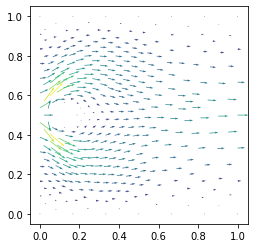

In [ ]:
plot(uh)

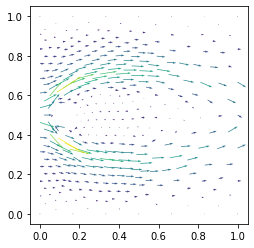

In [ ]:
plot(uh)
folder1 = str('/content/drive/My Drive/research/FLUID/u_H.pvd')
vtkfile = File(folder1)
vtkfile << uh

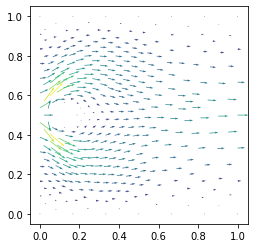

In [ ]:
plot(uh)
folder1 = str('/content/drive/My Drive/research/FLUID/u_L.pvd')
vtkfile = File(folder1)
vtkfile << uh

In [ ]:
def my_LK_fun(x,z,d):
      pi = 3.14159265359
      pi_s = pi
      L_c = 1.0/8.0
      L_p = np.max([1.0, 2.0*L_c])
      L_c_s = L_c
      L_p_s = L_p
      L = L_c/L_p
      L_s = L
      string = -1.88+sqrt(sqrt( pi_s )*  L_s /2.0)* z[0]
      for j in range(2, input_dim):
        term = z[j-1]*sqrt(sqrt(pi_s)*L_s )*exp(-pow(np.floor(j/2.0)* pi*L_s,2.0)/8.0)
        if j % 2 == 0:
          term = term*sin(np.floor(j/2.0)* pi_s*x/L_p_s)
        else:
          term = term*cos(np.floor(j/2.0)* pi_s*x/L_p_s)
        string = string + term
      string = np.exp(  string )

my_LK_fun(string) 

m=1
list_mu=[]
input_dim =4
for k in range(m):  
    d= input_dim 
    y_in_test = 2.0*np.random.rand(d,m) - 1.0
    z = y_in_test[:,i]
    pi = 3.14159265359
    pi_s = pi
    L_c = 1.0/8.0
    L_p = np.max([1.0, 2.0*L_c])
    L_c_s = L_c
    L_p_s = L_p
    L = L_c/L_p
    L_s = L
    string = -1.88+sqrt(sqrt( pi_s )*  L_s /2.0)* z[0]
    for j in range(2, input_dim):
      term = z[j-1]*sqrt(sqrt(pi_s)*L_s )*exp(-pow(np.floor(j/2.0)* pi*L_s,2.0)/8.0)
      if j % 2 == 0:
        term = term*sin(np.floor(j/2.0)* pi_s*x/L_p_s)
      else:
        term = term + '*cos(floor(' + str(j) + '/2.0)*' + pi_s + '*x/' + L_p_s + ')'
      string = string + '+' + term
    string = 'exp(' + string + ')'
    mu = Expression(str2exp(string), degree=2, domain=mesh)
    mu_h =project(mu,Ph)
    n_mu = max(mu_h.compute_vertex_values())
    list_mu.append(n_mu)



In [ ]:
np.floor(j/2.0)


1.0

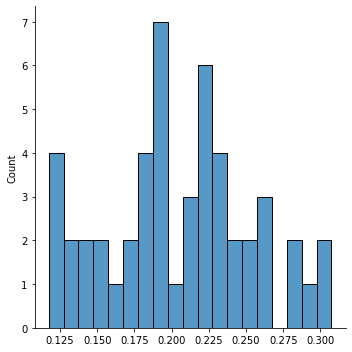

In [ ]:
import seaborn as sns
sns.displot(list_mu, binwidth=0.01)

In [ ]:
# Save the training and test#
scratchdir = '/content/drive/My Drive/research/DNN_BANACH_NSE_REAL/result_m_'+str(Nu)+''
projectdir = '/content/drive/My Drive/research/DNN_BANACH_NSE_REAL/result_m_'+str(Nu)+''
result_folder  = scratchdir + '/results_mesh' +str(nk)+ '_FE_degree_'+ str(deg)+'_no_p'
scratch_folder = scratchdir + '/results_mesh' +str(nk)+ '_FE_degree_'+ str(deg)+'_no_p'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)    
if not os.path.exists(scratch_folder): 
    os.makedirs(scratch_folder)

print('Generated inputs of size: ', y_in_test.shape)
print('Generated outputs of size: ', All_Train_coeff[0][0].shape)

run_data = {}
run_data['d']              = d
run_data['K']              = K
run_data['Nu']             = Nu
run_data['mesh_op']        = nk
run_data['FE_degree']      = deg
run_data['m']              = m
# run_data['m_test']         = m_test


#===============================================
# DOF Coeff- for each function separate
#===============================================    

run_data['All_Train_coeff']     = All_Train_coeff
#run_data['All_Test_coeff']      = All_Test_coeff
run_data['All_Train_coeff_p']     = All_Train_coeff_p
#run_data['All_Test_coeff_p']     = All_Test_coeff_p
#run_data['y_in_test_data']      = y_in_test
run_data['y_in_train_data']      = y_in_train
#run_data['w_test_weights']      = w_test_weights

run_data['fenics_mesh_coords']       = np.array(mesh.coordinates())
run_data['fenics_mesh_cells']        = np.array(mesh.cells())
run_data['fenics_mesh_num_cells']    = np.array(mesh.num_cells())
run_data['fenics_mesh_num_edges']    = np.array(mesh.num_edges())
run_data['fenics_mesh_num_vertices'] = np.array(mesh.num_vertices())
run_data['fenics_mesh_hmax']         = np.array(mesh.hmax())
run_data['fenics_mesh_hmin']         = np.array(mesh.hmin())
run_data['fenics_mesh_rmax']         = np.array(mesh.rmax())
run_data['fenics_mesh_rmin']         = np.array(mesh.rmin())
sio.savemat(result_folder + '/run_data_test.mat', run_data)

Generated inputs of size:  (4, 18945)
Generated outputs of size:  (94159,)


In [ ]:
%cd drive/MyDrive/research
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
# Other libraries
import scipy.io as sio
from fenics import *
#import Tasmanian
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import linalg as la
import time, os, argparse, io, shutil, sys, math, socket
import scipy.io as sio
from dolfin import *
import sympy2fenics as sf
import random

/content/drive/MyDrive/research


In [ ]:

def extract_specific_function(T_list,k):
    Z = []
    num = len(T_list)
    for  j in range(num):
      Z.append(T_list[j][k])
    coeff = np.array(Z).T
    return coeff

def str2exp(s):
    return sf.sympy2exp(sf.str2sympy(s))

# Hyperparameters
lr = 0.001
for s in [5]:
    #WEIGHT_DECAY       = 0.001
    #LEARNING_RATE      = 0.001
    nb_layers          = 1*s
    nb_nodes_per_layer = 10*s
    nb_nodes_per_layer_RT = 10*s
    Re = Constant(7.5)

    start_time         = time.time() 
    activation         =  tanh  
    activation_te      =  tanh  
    optimizer          =  Adam 
    initializer        =  he_normal 
    lrn_rate_schedule  =  exp_decay 
    type_loss          =  customize 
    blocktype          =  default 
    sigma              = 0.1 
    error_tol          = 5e-7
    quiet              = 0
    trial              = 1
    nb_epochs          = 20001
    nb_trials          = 1
    best_loss          = 10
    Id = Constant(((1.,0.),(0.,1.)))

    if initializer ==  normal :
        weight_bias_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev= sigma, seed = trial)
    elif initializer ==  uniform :
        weight_bias_initializer = tf.keras.initializers.RandomUniform(minval= -sigma, maxval= sigma, seed= trial)
    elif initializer ==  constant :
        weight_bias_initializer = tf.keras.initializers.Constant(value= sigma)
    elif initializer ==  he_normal :
        weight_bias_initializer = tf.keras.initializers.HeNormal(seed= trial)
    elif initializer ==  xavier_normal :
        weight_bias_initializer = tf.keras.initializers.GlorotNormal(seed= trial)    
    elif initializer ==  xavier_uniform :
        weight_bias_initializer = tf.keras.initializers.GlorotUniform(seed= trial)        
    else:
        sys.exit( initializer must be one of the supported types, e.g., normal, uniform, etc. )
    if lrn_rate_schedule ==  exp_decay :
        init_rate = 1e-3
        lrn_rate  = init_rate 

        # decay steps specifies how many epochs until the learning rate is 
        # decayed by specific amount
        decay_steps = 1e3

        # calculate the base so that the learning rate schedule with exponential 
        # decay follows (init_rate)*(base)^(current_epoch/decay_step)
        base = np.exp(decay_steps/nb_epochs*(np.log(error_tol)-np.log(init_rate)))

        # base on the above, the final learning rate is (init_rate)*(base)^(total_epoch/decay_step)
        print( based on init rate =   + str(init_rate)
                +  , decay_steps =   + str(decay_steps)
                +  , calculated base =   + str(base)
                +  , so that after   + str(nb_epochs)
                +   epochs we have final learning rate =  
                + str(init_rate*base**(nb_epochs/decay_steps)))
            
        decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            init_rate, decay_steps, base, staircase= False, name= None)
    else:
        print( incorrect learning rate schedule selected ) 
    standard_opt = tf.keras.optimizers.Adam(
                learning_rate= decay_schedule,
                beta_1= 0.9, beta_2= 0.999, epsilon= 1e-07,
                name=  Adam 
            ) 
    #Data set
    # type of sampling 
    for Nu in [600]:
        nk                 = 2
        deg                = 1
        d                  = 4
        scratchdir      =  /content/drive/My Drive/research/DNN_BANACH_NSE_REAL_d +str(d)+ /result_m_ +str(Nu)+  
        projectdir_test =  /content/drive/My Drive/research/DNN_BANACH_NSE_REAL_d +str(d)+ /result_m_ +str(1)+  
        result_folder  = scratchdir      +  /results_mesh  +str(nk)+  _FE_degree_ + str(deg)+ _no_p 
        test_folder    = projectdir_test +  /results_mesh  +str(nk)+  _FE_degree_ + str(deg)+ _no_p 
        mat_contentst = sio.loadmat(result_folder +  /run_data_test.mat )
        mat_test      = sio.loadmat(test_folder +  /run_data_test.mat )
        mat_contentst
        sorted(mat_contentst.keys())
        sorted(mat_test.keys())
        m      = mat_contentst[ m ][0][0]
        BATCH_SIZE         = int(m/5)
        m_test = mat_test[ m_test ][0][0]
        input_dim = int(np.float32(mat_contentst[ d ][0][0]))
        d = input_dim


        # FE spaces
        meshname="meshes/obstac%03g.xml"%nk
        mesh = Mesh(meshname)
        nn   = FacetNormal(mesh)
        Pkv = VectorElement( DG , mesh.ufl_cell(), deg)
        Pk  = FiniteElement( DG , mesh.ufl_cell(), deg)
        RTv = FiniteElement( RT , mesh.ufl_cell(), deg+1)
        R0  = FiniteElement( R , mesh.ufl_cell(), 0)
        Hh  = FunctionSpace(mesh, MixedElement([Pkv,Pk,Pk,Pk,RTv,RTv,R0]))
        Ph  = FunctionSpace(mesh, CG ,1)
        soltrue = Function(Hh)
        solDNN  = Function(Hh)
        # pressure
        PDNN_h       = Function(Ph)
        PSOL_h       = Function(Ph)


        nb_in_train_pts = m
        y_in_train_data  = mat_contentst[ y_in_train_data ]
        y_in_test_data  = mat_test[ y_in_test_data ]
        All_Train_coeff = mat_contentst[ All_Train_coeff ]
        All_Test_coeff  = mat_test[ All_Test_coeff ]
        # pressure
        All_Train_coeff_p = mat_contentst[ All_Train_coeff_p ]
        All_Test_coeff_p  = mat_test[ All_Test_coeff_p ]
        w_test_weights    = mat_test[ w_test_weights ]
        deg               = mat_contentst[ FE_degree ]
        w_test_weights    = w_test_weights.T
        u_train_data       =  extract_specific_function(All_Train_coeff,0).T
        te11_train_data    =  extract_specific_function(All_Train_coeff,1).T
        te12_train_data    =  extract_specific_function(All_Train_coeff,2).T
        te21_train_data    =  extract_specific_function(All_Train_coeff,3).T
        # pressure
        p_train_data       =  All_Train_coeff_p




        output_dim = u_train_data.shape[1]
        # pressure
        output_dim_p = p_train_data.shape[1]
        nb_train_pts = m
        nb_test_pts  = m_test
        x_train_data =  y_in_train_data.T
        x_test_data  =  y_in_test_data.T
        
        # save relevant run data for loading into MATLAB, some items will 
        # be updated by callback
        run_data = {}
        run_data[ optimizer ] = optimizer  
        run_data[ error_tol ] = error_tol
        run_data[ activation ] = activation
        run_data[ nb_layers ] = nb_layers
        run_data[ nb_nodes_per_layer ] = nb_nodes_per_layer
        run_data[ nb_train_points ] = nb_train_pts
        run_data[ nb_test_points ] = nb_test_pts
        run_data[ nb_epochs ] = nb_epochs
        run_data[ blocktype ] = blocktype
        run_data[ initializer ] = initializer

        run_data[ start_time ] = start_time
        run_data[ timestamp ] = 0 
        run_data[ tf_version ]  = tf.__version__
        run_data[ input_dim ] = input_dim
        run_data[ output_dim ] = output_dim
        run_data[ model_save_folder ] =  model_save 
        print( mesh                 :   + str(nk))
        print( Finite element degree:   + str(deg))
        print( Training points      :   + str(m))
        print( Testing points       :   + str(m_test))


        # Functional API
        all_layers_u = []
        all_layers_te11 = []
        all_layers_te12 = []
        all_layers_te21 = []
           
        all_layers_si1 = []
        all_layers_si2 = []
           
        #pressure
        all_layers_p = []
        inputs = keras.Input(shape=(input_dim,), name =  input_y )
        branch_u =tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name= branch_u ,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(inputs)
        branch_te11 =tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name= branch_te11 ,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(inputs)

        branch_te12 =tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name= branch_te12 ,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(inputs)

        branch_te21 =tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name= branch_te21 ,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(inputs)
                                     
        # pressure                                        
        branch_p  =tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name= branch_p ,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(inputs)                                       


        all_layers_u.append(branch_u)
        all_layers_te11.append(branch_te11)
        all_layers_te12.append(branch_te12)
        all_layers_te21.append(branch_te21)
        all_layers_p.append(branch_p)

        for layer in range(nb_layers):
            layer_name_u  =  dense_u  + str(layer)
            layer_name_te11 =  dense_te11  + str(layer)
            layer_name_te12 =  dense_te12  + str(layer)
            layer_name_te21 =  dense_te21  + str(layer)
            
            layer_name_p =  dense_p  + str(layer)

            this_layer_u = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name=layer_name_u,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(all_layers_u[layer])
            this_layer_te11 = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name=layer_name_te11,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(all_layers_te11[layer])

            this_layer_te12 = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name=layer_name_te12,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(all_layers_te12[layer])

            this_layer_te21 = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name=layer_name_te21,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(all_layers_te21[layer])
            # pressure                                       
            this_layer_p = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                                activation=activation,
                                                name=layer_name_p,
                                                kernel_initializer= weight_bias_initializer,
                                                bias_initializer= weight_bias_initializer,
                                                dtype=tf.float32)(all_layers_p[layer]) 
            all_layers_u.append(this_layer_u)
            all_layers_te11.append(this_layer_te11)
            all_layers_te12.append(this_layer_te12)
            all_layers_te21.append(this_layer_te21)

            # pressure 
            all_layers_p.append(this_layer_p)

        final_num = layer+1
        first_output_layer_u = tf.keras.layers.Dense(output_dim,
                                                    activation= tf.keras.activations.linear,
                                                    trainable=True,
                                                    use_bias=False,
                                                    name= output_u ,
                                                    kernel_initializer=weight_bias_initializer,
                                                    dtype=tf.float32)(all_layers_u[final_num])
        first_output_layer_te11 = tf.keras.layers.Dense(output_dim,
                                                    activation= tf.keras.activations.linear,
                                                    trainable=True,
                                                    use_bias=False,
                                                    name= output_te11 ,
                                                    kernel_initializer=weight_bias_initializer,
                                                    dtype=tf.float32)(all_layers_te11[final_num])

        first_output_layer_te12 = tf.keras.layers.Dense(output_dim,
                                                    activation= tf.keras.activations.linear,
                                                    trainable=True,
                                                    use_bias=False,
                                                    name= output_te12 ,
                                                    kernel_initializer=weight_bias_initializer,
                                                    dtype=tf.float32)(all_layers_te12[final_num])

        first_output_layer_te21 = tf.keras.layers.Dense(output_dim,
                                                    activation= tf.keras.activations.linear,
                                                    trainable=True,
                                                    use_bias=False,
                                                    name= output_te21 ,
                                                    kernel_initializer=weight_bias_initializer,
                                                    dtype=tf.float32)(all_layers_te21[final_num])

        first_output_layer_p = tf.keras.layers.Dense(output_dim_p,
                                                    activation= tf.keras.activations.linear,
                                                    trainable=True,
                                                    use_bias=False,
                                                    name= output_p ,
                                                    kernel_initializer=weight_bias_initializer,
                                                    dtype=tf.float32)(all_layers_p[final_num])                                              

        DNN = tf.keras.Model(inputs=inputs, outputs=[first_output_layer_u,
                                                    first_output_layer_te11,
                                                    first_output_layer_te12,
                                                    first_output_layer_te21,
                                                    first_output_layer_p])



        DNN.summary()

            #------------------------------------------------------------------------------# 
            # Define tf.functions 
            #------------------------------------------------------------------------------#
        @tf.function
        def get_u(y):
            y = tf.convert_to_tensor(y)    
            uy = DNN(y)[0]
            return uy # Cofficients 
        @tf.function
        def get_te11(y):
            y = tf.convert_to_tensor(y)    
            uy = DNN(y)[1]
            return uy # Cofficients 

        @tf.function
        def get_te12(y):
            y = tf.convert_to_tensor(y)    
            uy = DNN(y)[2]
            return uy # Cofficients 

        @tf.function
        def get_te21(y):
            y = tf.convert_to_tensor(y)    
            uy = DNN(y)[3]
            return uy # Cofficients 
        @tf.function
        def get_p(y):
            y = tf.convert_to_tensor(y)    
            uy = DNN(y)[4]
            return uy # Cofficients 

        @tf.function
        def get_mse(y,u_true,te11,te12,te21,p):
            # minimize solution u on Omega x[0,T]
            mse_1 = tf.reduce_mean((get_u(y)- u_true)**2)
            mse_2 = tf.reduce_mean((get_te11(y)- te11)**2)
            mse_3 = tf.reduce_mean((get_te12(y)- te12)**2)
            mse_4 = tf.reduce_mean((get_te21(y)- te21)**2)
            mse_7 = tf.reduce_mean((get_p(y)- p)**2)
              
            return mse_1 + mse_2 + mse_3 + mse_4 + mse_7
        adam = tf.keras.optimizers.Adam(1e-4)
        @tf.function
        def GD(y,u_true,te11,te12,te21,p):
            with tf.GradientTape() as g:
                g.watch(DNN.variables)
                mse = get_mse(y,u_true,te11,te12,te21,p)
            G = g.gradient(mse,DNN.variables)
            adam.apply_gradients(zip(G,DNN.variables))   

        # Data inside the domain
        y_test        = tf.cast(np.asarray(x_test_data), tf.float32)
        var2          = tf.cast(np.asarray(All_Test_coeff), tf.float32)
        varp          = tf.cast(np.asarray(All_Test_coeff_p), tf.float32)



        # Auxiliary variables
        L2_error_data   = np.array([])
        L4u_err_append  = np.array([])
        L2t_err_append  = np.array([])
        L2si_err_append = np.array([])
        L2p_err_append  = np.array([])
        Hdiv_err_append = np.array([])

        for epoch in range(nb_epochs):
            I_ad  = np.array([])          
            I_new = np.array([]) 
            I     = np.array([])
            batch_size = int(BATCH_SIZE)
            I_i   = range(nb_in_train_pts)
            I_ad = random.sample(I_i, batch_size)
            I    = np.append(I, I_ad).astype(int)
            # Data inside the domain
            y_in     = tf.cast(np.asarray(x_train_data)[I,:], tf.float32)
            u_in     = tf.cast(np.asarray(u_train_data)[I,:], tf.float32)
            te11_in  = tf.cast(np.asarray(te11_train_data)[I,:], tf.float32)
            te12_in  = tf.cast(np.asarray(te12_train_data)[I,:], tf.float32)
            te21_in  = tf.cast(np.asarray(te21_train_data)[I,:], tf.float32)

            p_in     = tf.cast(np.asarray(p_train_data)[I,:], tf.float32)
            
            # gradient descent
            GD(y_in,u_in,te11_in,te12_in,te21_in,p_in)
            # compute loss
            res = get_mse(y_in,u_in,te11_in,te12_in,te21_in,p_in)
            L2_error_data = np.append(L2_error_data, res)
            if (epoch % 100 ==0):
              print( ============================================================ )
              print( Epochs:   + str(epoch) +   | Error:   + str("{:.4e}".format(res)) )
              print( ============================================================ )
                
            
            if (epoch % 1000 == 0):    
                u_pred     = DNN(y_test)  
                u_coef_pred= u_pred[0:4]
                u_pred_p     = tf.cast(u_pred[4], dtype= tf.float32)
                u_pred       = tf.cast(u_coef_pred, dtype= tf.float32)

                L4u_err = 0.0
                L2t_err = 0.0
                L2si_err = 0.0
                L2p_err = 0.0
                Hdiv_err= 0.0
                max_weight = 0.0
                for i in range(m_test):
                    #parameters
                    z = x_test_data[i,:]
                    #string =  5.0+exp(  + str(z[0]) +  *x+  + str(z[1]) +  *y)  
                    # Reconstruction of mu
                     
                    
                    # this var makes the proces faster
                    var  = u_pred[0][0,:]*0    
                    # this var makes the proces faster
                    for k in range(4):
                        var = var + u_pred[k][i,:]
                    var_aux_u = np.array(var)
                    
                    var3 = np.array(var2[i,:])
                    # pressure
                    var_p= np.array(u_pred_p[i,:])
                    var_aux_u_real = np.array(var3)
                    var_aux_p_real = np.array(varp[i,:])
                    #REAL

                    soltrue.vector().set_local(var_aux_u_real) 
                    PSOL_h.vector().set_local(var_aux_p_real)
                    #DNN
                    solDNN.vector().set_local(var_aux_u)
                    PDNN_h.vector().set_local(var_p)
                    u_sol, t11, t12, t21, Rsig1, Rsig2, xi        = soltrue.split()
                    uh, t11h, t12h, t21h, Rsigh1, Rsigh2, xih     = solDNN.split()
                    t =as_tensor(((t11,t12),(t21,-t11)))   
                    th =as_tensor(((t11h,t12h),(t21h,-t11h)))  
                    sigma_dn = as_tensor((Rsig1,Rsig2))
                    if (epoch == run_data[ nb_epochs ]-1):
                        pi = 3.14159265359
                        pi_s = str(pi)
                        L_c = 1.0/8.0
                        L_p = np.max([1.0, 2.0*L_c])
                        L_c_s = str(L_c)
                        L_p_s = str(L_p)
                        L = L_c/L_p
                        L_s = str(L)
                        string =  -4.5+sqrt(sqrt(  + pi_s +  )*  + L_s +  /2.0)*  + str(z[0])
                        for j in range(2, input_dim):
                          term = str(z[j-1]) +  *sqrt(sqrt(  + pi_s +  )*  + L_s +  )*exp(-pow(floor( 
                          term = term + str(j) +  /2.0)*  + pi_s +  *  + L_s +  ,2.0)/8.0)  
                          if j % 2 == 0:
                            term = term +  *sin(floor(  + str(j) +  /2.0)*  + pi_s +  *x/  + L_p_s +  ) 
                          else:
                            term = term +  *cos(floor(  + str(j) +  /2.0)*  + pi_s +  *x/  + L_p_s +  ) 
                          string = string +  +  + term
                        string =  exp(  + string +  ) 
                        mu = Expression(str2exp(string), degree=2, domain=mesh)
                        sigmah   = 2.*mu*sym(th) - 0.5*outer(uh,uh) - PDNN_h*Id 
                        error_L2si = sqrt(assemble((sigma_dn-sigmah)**2*dx) )
                        error_Hdivsi =   pow(  assemble(  ( pow(  ( div(sigma_dn)-div(sigmah)  )**2,2.0/3.0 )**1*dx)  )  , 3.0/4.0 ) 
                        L2si_err = L2si_err  + np.abs(error_L2si)**(2.0)*w_test_weights[i]
                        Hdiv_err = Hdiv_err + np.abs(assemble(  ( pow(  ( div(sigma_dn)-div(sigmah)  )**2,2.0/3.0 )**1*dx)  ))*w_test_weights[i]
                        
                      



                    #sigmah = as_tensor((Rsigh1,Rsigh2))                    
                    error_L4u  = sqrt(sqrt(assemble( ((u_sol-uh)**2)**2*dx)))
                    error_L2t  = sqrt(assemble((th-t)**2*dx))
                    error_L2p  = sqrt(assemble((PDNN_h-PSOL_h)**2*dx) ) 
                    L4u_err = L4u_err  + np.abs(np.abs(error_L4u)**(2.0))**(1.0)*w_test_weights[i]
                    L2t_err = L2t_err  + np.abs(error_L2t)**(2.0)*w_test_weights[i]
                    L2p_err = L2p_err  + np.abs(error_L2p)**(2.0)*w_test_weights[i]
                    #modify for sigma
                L4u_err = np.sqrt(np.abs(L4u_err/2**(d)))
                L2t_err = np.sqrt(np.abs(L2t_err/2**(d)))
                if (epoch == run_data[ nb_epochs ]-1):
                    L2si_err = np.sqrt(np.abs(L2si_err/2**(d)))  
                    Hdiv_err = L2si_err + np.sqrt(np.abs(Hdiv_err/2**(d)))  
                    L2si_err_append = np.append(L2si_err_append, L2si_err)   
                L2p_err = np.sqrt(np.abs(L2p_err/2**(d)))
                #modify for sigma            
                # Append
                L4u_err_append =  np.append(L4u_err_append, L4u_err)  
                L2t_err_append =  np.append(L2t_err_append, L2t_err) 
                L2p_err_append =  np.append(L2p_err_append, L2p_err) 
                #modify for sigma
                Hdiv_err_append = np.append(Hdiv_err_append, Hdiv_err) 
                print( Epochs:   + str(epoch) +   | Error:   + str("{:.4e}".format(res)) )
                print( Testing errors: L4u_e = %4.3e, L2t_e= %4.3e,L2p_e = %4.3e  % (L4u_err, L2t_err,L2p_err))  
                if (epoch == run_data[ nb_epochs ]-1): 
                    print( Testing errors: L4u_e = %4.3e, L2t_e= %4.3e,L2si_e = %4.3e,L2p_e = %4.3e  % (L4u_err, L2t_err,L2si_err,L2p_err)) 
          

          
              
                
            if (res <= run_data[ error_tol ]) or (epoch == run_data[ nb_epochs ]-1):
                if res <= best_loss:
                    best_loss = res
                    folder1 = str( /content/drive/My Drive/research/DNN_BANACH_NSE_REAL_d +str(d)+ /DATA_2022_AUG_2BOX/ +  data_m_ +str(Nu)+ _deg_ +str(deg[0][0])+ _mesh_ +str(nk)+ _af_ +activation+  +str(nb_layers)+ x +str(nb_nodes_per_layer)+  /u_DNN.pvd )
                    folder2 = str( /content/drive/My Drive/research/DNN_BANACH_NSE_REAL_d +str(d)+ /DATA_2022_AUG_2BOX/ +  data_m_ +str(Nu)+ _deg_ +str(deg[0][0])+ _mesh_ +str(nk)+ _af_ +activation+  +str(nb_layers)+ x +str(nb_nodes_per_layer)+  /u_REA.pvd )
                    vtkfile = File(folder1)
                    vtkfile << uh
                    vtkfile = File(folder2)
                    vtkfile << u_sol
                    #DNN.save(result_folder +  /model_save_folder )

        # Testing error     
        #L2_error_u = np.sqrt(np.sum(np.square(np.abs(u_pred-u_test_data)))/nb_test_pts)
        #L2_error_f = np.sqrt(np.sum(np.square(np.abs(Lu_pred-Lu_test_data)))/nb_test_pts)

        print( L2 error u at the end of training:   + str(L4u_err))
        #print( L2 error f at the end of training:  + str(L2_error_f))           
        scratchdir      =  /content/drive/My Drive/research/DNN_BANACH_NSE_REAL_d +str(d)+ /DATA_2022_AUG_2BOX/ 
        
           
        result_folder_dump  = scratchdir      +  data_m_ +str(Nu)+ _deg_ +str(deg[0][0])+ _mesh_ +str(nk)+ _af_ +activation+  +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _     
        
  
        # Save data 
        #run_data[ u_pred ] = DNN(y_test)
        run_data[ L4u_err_af_ +activation+ _Npl +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _m_ +str(Nu)+  ]    = L4u_err_append
        run_data[ L2t_err_af_ +activation+ _Npl +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _m_ +str(Nu)+  ]    = L2t_err_append
        run_data[ L2p_err_af_ +activation+ _Npl +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _m_ +str(Nu)+  ]    = L2p_err_append   
        run_data[ L2si_err_af_ +activation+ _Npl +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _m_ +str(Nu)+  ]   = L2si_err_append   
        run_data[ residual_af_ +activation+ _Npl +str(nb_layers)+ x +str(nb_nodes_per_layer)+ _m_ +str(Nu)+  ]   = L2_error_data 

        
        # save the resulting mat file with scipy.io
        sio.savemat(result_folder_dump +  _final.mat , run_data)

based on init rate = 0.001, decay_steps = 1000.0, calculated base = 0.6838435458429123, so that after 20001 epochs we have final learning rate = 4.999999999999997e-07
mesh                 : 2
Finite element degree: [[1]]
Training points      : 600
Testing points       : 401
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_y (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 branch_u (Dense)               (None, 50)           250         ['input_y[0][0]']                
                                                                                                  
 branch_te11 (Dense)            (None, 50)           250         ['input_y[0][0]']                
               